# Machine Learning for Healthcare (ML4H) - Exercise 3 
### By Eva van Weenen

This notebook contains the solutions to exercise 3 of the **Machine Learning for Healthcare** course. 
Using the PubMed 200k dataset consisting of abstracts from PubMed, we try to classify to which section of the abstract it belongs, i.e. background, objective, methods, results, conclusions. For this purpose, we try three different methods: *tf-idf*, *word2vec* and *bluebert*. Each part can be viewed underneath.

We evaluate each model with a classification report (showing the precision, recall and F1-score, for each label), as well as a confusion matrix, and an ROC-curve. With these models, we obtain the following *weighted F1-scores* on the test set: 

**model** | **weighted F1-score**
:--- | :---:
tf-idf | 0.80
word2vec | 0.73
BlueBert (not fine-tuned) | 0.74
BlueBert (fine-tuned) | 0.86

As you can see, the fine-tuned BlueBert model obtains the best performance on the test set. For the performance of this model, please scroll down.

*Note: I ran the models in a script (see `main.py` and `read.py`), and then realized only afterwards that I should hand in a notebook instead of a script. Therefore I only load the models in the script, and leave these cells in the notebook inactive.*

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm
import gc

sns.set()
sns.set_context('paper')
sns.set_style('white')

## Data
Preprocessing and plotting some basics

### Preprocessing

Each line of text in the data provided has to be preprocessed before we can use it in the model. We use the following preprocessing steps.

1. Only select lines that 
    1. do not start with # (to remove abstract IDs)
    2. are not empty (i.e. `\n`)
    3. that contain the clinical trial number
2. Split the label and text using the tab identifier.
3. Remove the `\n` character from the end of each line in the text.
4. Transform all capital letters to lower cases.
5. Remove any word that starts with `http` or `www`, to remove websites.
6. Remove all punctuation and replace with spaces.
7. Tokenization: splitting up sentences in separate words.
8. Remove stopwords.
9. POS tagging
10. Lemmatize adjectives, verbs, nouns and adverbs, separately using their POS tag. If the POS tag identifies the word as a number, replace the number with `NUM`.
11. Only write to file if line is not empty.

In [2]:
import string
import re

from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk import pos_tag as POSTag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader import wordnet

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lem = WordNetLemmatizer()

def postag_to_wordnet(tag):
	if tag.startswith('J'):
		return wordnet.ADJ
	elif tag.startswith('V'):
		return wordnet.VERB
	elif tag.startswith('N'):
		return wordnet.NOUN
	elif tag.startswith('R'):
		return wordnet.ADV
	else:
		return None

def preprocess_text(text):
	# TODO: typos and misspellings
	# TODO: identify medical abbreviations
	# TODO: identify diseases and other medical terms

	# remove end of line
	text = text.rstrip('\n')

	# lowercasing
	text = text.lower()

	# remove anything starting with http or www
	text = re.sub(r"http\S+", '', text)
	text = re.sub(r"www.\S+", '', text)

	# punctuation removal (and replace with whitespace)
	text = re.sub(r"""[%s]+\ *"""%string.punctuation, " ", text)

	# tokenization
	text = word_tokenize(text)

	# stop-words removing
	text = [word for word in text if word not in stopwords.words('english')]

	# pos tagging
	tag = list(map(lambda x: (x[0], x[1], postag_to_wordnet(x[1])), POSTag(text)))

	# lemmatization (+ replace numbers with a num tag)
	text = ['NUM' if pos == 'CD' else (word if wn is None else lem.lemmatize(word, wn)) for word, pos, wn in tag]

	return text

def preprocess(path_in, path_out):
	"""
	Read raw data, preprocess, and write back to file
	"""
	if path_in.endswith('val.txt'):
		path_in = path_in[:-7] + 'dev.txt'

	Y = [] # labels

	with open(path_in, 'r') as f_in, open(path_out+'_x.txt', 'w') as f_out:
		for line in tqdm(f_in):
			# remove abstract splits and file IDs as well as clinical trial registry line
			if line.startswith('#') or line == '\n' or 'clinicaltrials.gov' in line.lower():
				continue

			# split by label and text
			label, text = line.split('\t')[:2]

			# preprocess text
			text = preprocess_text(text)

			# only write non-empty lines
			if ' '.join(text).strip() != '':
				# write preprocessed text to file
				f_out.write(' '.join(text) + '\n')
				
				Y.append(label)

	np.savetxt(path_out+'_y.txt', Y, fmt='%s')

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/evanweenen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/evanweenen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /local/home/evanweenen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /local/home/evanweenen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Carry out preprocessing for `train`, `val` and `test`

In [ ]:
for split in ('train', 'val', 'test'):
	# read and preprocess
	preprocess(path_in='./data/PubMed_200k_RCT/'+split+'.txt', path_out='./data/'+split)

Open preprocessed data

In [3]:
def read_text(datadir, split):
	with open(datadir+split+'_x.txt', 'r') as file:
		text = file.read().split('\n')[:-1]
	return text

data = {'x'	: {split: read_text('./data/', split) for split in ('train', 'val', 'test')},
		'y'	: {split: np.loadtxt('./data/'+split+'_y.txt', dtype='str') for split in ('train', 'val', 'test')}}

**Basic plotting**

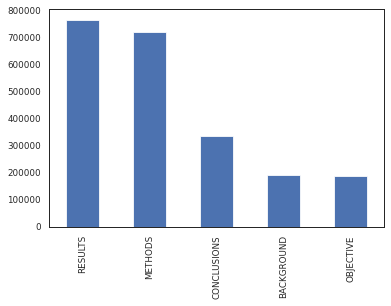

In [4]:
# label distribution
pd.Series(data['y']['train']).value_counts().plot.bar()
plt.show() 

You can see that there is an imbalance in the data, with "RESULTS" and "METHODS" being overly represented, and "BACKGROUND" and "OBJECTIVE" being much less represented.

## TF-IDF


We calculate the tf-idf of each word in a sentence, and use this as an input of the classifier.

The *tf-idf* is calculated as follows:
- The *term-frequence (tf)* is the frequency of term $t$ in document $d$, i.e.,
$$ tf(t,d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t', d}}\,, $$
where $f_{t,d}$ is the raw count of term $t$ in document $d$.
- The *inverse document frequency (idf)* is a measure of how much information the word provides, i.e.,
$$ idf(t,D) = \log \frac{|D|}{|\{d\in D : t\in d\}|}\,, $$
where $|D|$ is the length of the set of all documents, and $|\{d\in D : t\in d\}|$ is the number of ducments in which term $t$ appears.

This is the official definition of the *tf-idf*. However, in our case, we don't have a collection of *documents*, but we have a collection of *sentences*. Therefore, the $d$ in the equation above refers to one sentences, and $D$ refers to the set of all sentences.

Now we define $T$ as the set of all unique words in our data (collection of sentences) $D$.

For each sentence in our text data $d$, we create a vector that is of the size of all unique words in the data ($|T|$). This vector represents the tf-idf of the sentence. 

Our final data that we use in the classifier is then of size $|D|\times |T|$.

**Binarize labels**

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.classes_ = np.array(['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'])
Y = {split : le.transform(data['y'][split]) for split in ('train', 'val', 'test')}

**Calculate tf-idf**

We keep only words that appear in 100 or more documents, and we try both unigrams and bigrams.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=100, ngram_range=(1,2), norm='l2')

X = {'train': tfidf.fit_transform(data['x']['train']),
	 'val'	: tfidf.transform(data['x']['val']),
	 'test'	: tfidf.transform(data['x']['test'])}

words = np.array(tfidf.get_feature_names())
print("Number of unique Unigrams and bigrams: ", len(words))

Number of unique Unigrams and bigrams:  39879


Print features with the highest **chi2**

In [7]:
from sklearn.feature_selection import chi2

print("Features with highest chi2: ")
for l, lname in enumerate(le.classes_):
	chi2_words = chi2(X['train'], Y['train'] == l)
	words_sorted = words[np.argsort(chi2_words[0])[::-1]]
	print(lname, words_sorted[:5])

Features with highest chi2: 
BACKGROUND ['num' 'num num' 'aim' 'current control' 'group']
OBJECTIVE ['investigate' 'whether' 'evaluate' 'aim' 'determine']
METHODS ['randomize' 'randomly' 'blind' 'double blind' 'significantly']
RESULTS ['num num' 'num' 'group' 'significant' 'significantly']
CONCLUSIONS ['may' 'effective' 'num' 'num num' 'suggest']


We see some words that are specific to each type of section in the abstract.

**Logistic regression**

We take L1 regularization due to the high number of features. This should set all irrelevant features to zero.

In [ ]:
from sklearn.linear_model import LogisticRegression

# regression
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X['train'], Y['train'])

# write to file
with open('./model/tfidf-classifier.pkl', 'wb') as file:
	pickle.dump(clf, file)

In [8]:
# read model
with open('./model/tfidf-classifier.pkl', 'rb') as file:
    clf = pickle.load(file)

Plot features with the highest coefficients

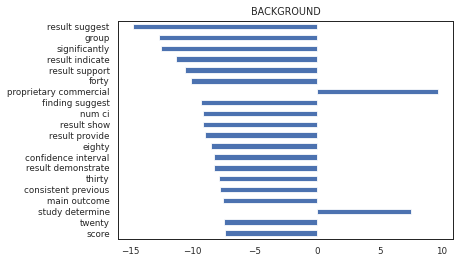

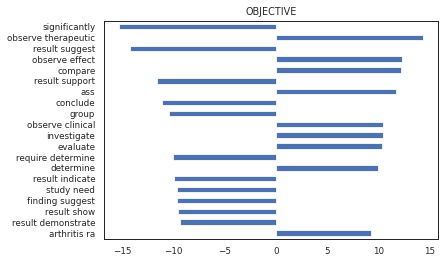

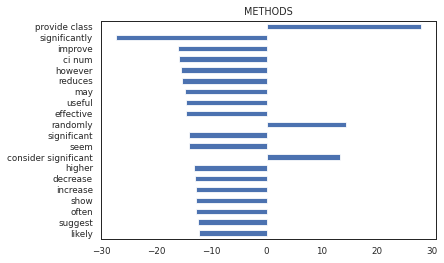

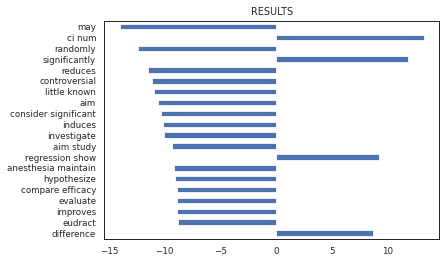

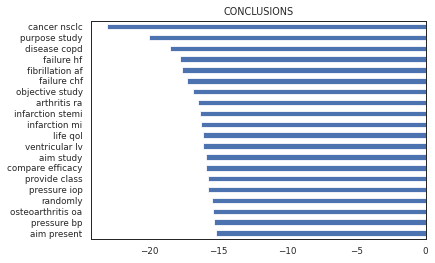

In [9]:
coefs = pd.DataFrame(clf.coef_.T, columns=le.classes_, index=words)
for i, lab in enumerate(le.classes_):
	idx = coefs[lab].abs().argsort()
	coefs[lab][idx][-20:].plot(kind='barh')
	plt.title(lab)
	plt.show()

A few obervations. 

Note that for background, the combination of words `study determine` has a high positive correlation with this label. Anything with `results` seems to have a negative correlation. This is in line with what one would expect of an abstract.

For objective, it is interesting to see that the words `observe effect`, `compare`, `observe clinical`, `investigate`, `evaluate` and `determine` all have a high positive correlation with the label. These are all words with a similar meaning, so if one would take a synset, this would probably give even stronger results.

The remainder of the labels are also in line with expectations. It is relatively funny that the word `may` has a strong negative correlation with the label results. The highest positive correlation with results, is `ci num`, which is simply the confidence interval, followed by a number. 


**Classification report**

In [10]:
from sklearn.metrics import classification_report

print("\n -------------- train -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['train'], clf.predict(X['train']), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- val -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['val'], clf.predict(X['val']), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- test -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['test'], clf.predict(X['test']), 
	target_names=le.classes_, output_dict=True)).T)


 -------------- train -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.642429  0.516655  0.572718  1.919210e+05
OBJECTIVE      0.711877  0.593919  0.647570  1.865540e+05
METHODS        0.853328  0.914935  0.883058  7.208580e+05
RESULTS        0.866038  0.878079  0.872017  7.662310e+05
CONCLUSIONS    0.741415  0.754160  0.747733  3.368130e+05
accuracy       0.815626  0.815626  0.815626  8.156256e-01
macro avg      0.763017  0.731550  0.744619  2.202377e+06
weighted avg   0.810275  0.815626  0.811530  2.202377e+06

 -------------- val -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.636640  0.499206  0.559609   2520.000000
OBJECTIVE      0.690058  0.584158  0.632708   2424.000000
METHODS        0.851137  0.910282  0.879716   9541.000000
RESULTS        0.856890  0.872607  0.864677   9977.000000
CONCLUSIONS    0.726718  0.738401  0.732513   4354.000000
accuracy       0.807885  0.807885  0.807885     

**Final score**

In [11]:
from sklearn.metrics import f1_score

print("F1-score (weighted) for test set: ", f1_score(Y['test'], clf.predict(X['test']), average='weighted'))

F1-score (weighted) for test set:  0.8029076791653351


We notice that the final score is already relatively high. We therefore do not do any hyperparameter-optimization (technically, we could have optimized the L1-regularization factor). For this reason, we do not need the validation set, and we report the F1-score on the *test* set.

**Confusion matrix**

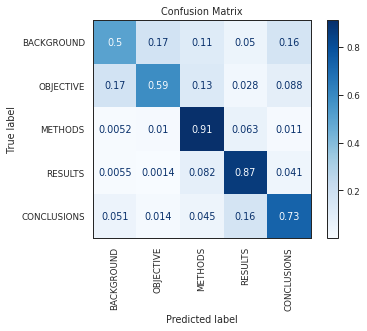

In [12]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X['test'], Y['test'], display_labels=le.classes_, 
	normalize='true', xticks_rotation='vertical', cmap='Blues')
plt.xlabel('Predicted label') ; plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**Receiver Operating Characteristic**

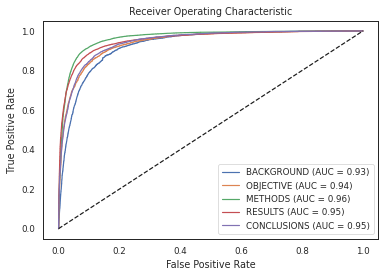

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
	fpr[i], tpr[i], _ = roc_curve(Y['test'] == i, clf.decision_function(X['test'])[:,i])
	roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(le.classes_)):
	plt.plot(fpr[i], tpr[i], label=le.classes_[i]+r' (AUC = %.2f)'%roc_auc[i])
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate') ; plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In conclusion, I think this model already achieves very high results. Personally, I did not know it was possible to get such high results, with such a simple model and real-world data.

In [14]:
del X ; gc.collect()

18344

## Word2Vec

Instead of representing a word as a *high-dimensional* tf-idf vector of the size of the vocabulary, we aim to represent a word as a point in a lower-dimensional space, i.e. an *embedding*. Using embeddings implies having an automatic measure of semantic similarity (association between words). 

The representation learning model that we use to create these embeddings is called *word2vec*. The main concept of this algorithm is that *similar context implies similar meaning*. It learns a lower-dimensional representation of a word, through an auto-encoder like model. Its bigram form (see image underneath) learns a one-hot encoded representation of a word, given a one-hot encoded representation of a word, where the hidden layer represents the final embedding of that word. 

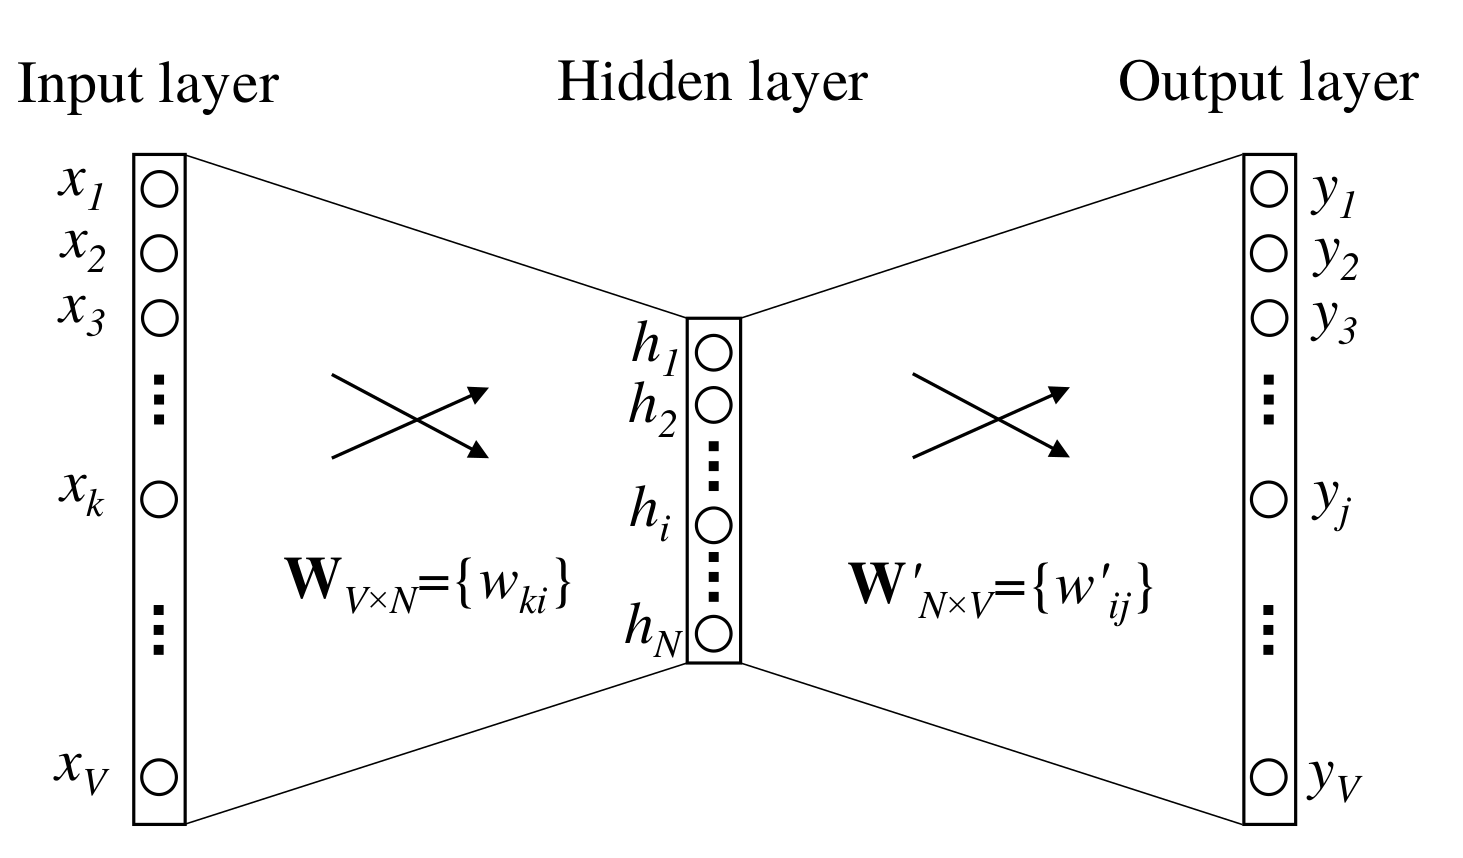

Word2vec consists of two forms: continuous bag-of-words (which learns a word, given its context), and skip-gram (which learns a context, given a word). The model that we use here is skip-gram. It's output is calculated as follows:

$$p(w_O | w_I ) = \frac{\exp{({v'_{w_O}}^\top v_{w_I})}}{\sum_{w\in V}\exp({v'_w}^\top v_{w_I})}$$

which is the softmax over the scalar product between the output representation of the context, and the input representation of a word.

The model is optimized by maximizing the average log probability, i.e.,

$$ \frac{1}{T} \sum^T_{t=1} \sum_{-c\leq j \leq c, j\neq 0 } \log p(w_{t+j} | w_t)\,, $$

where the first sum is over all training words, and the second sum is over the context window of a word.

Once this model is trained, we obtain the lower-dimensional representations (embeddings) for each word. Through aggregation of all these word embeddings in a sentence, we can create a lower-dimensional representation for each sentence. These sentence representations are then used as inputs of the classifier, similar to the tfidf vectors in the method above.

In [15]:
import multiprocessing

cores = multiprocessing.cpu_count()

Load text in right format

In [16]:
X_corpus = {split: [line.split() for line in data['x'][split]] for split in ('train', 'val', 'test')}

Build and train **word2vec** model. We use word2vec: skip-gram, with a window size of 5, and a vector size of 200. We ignore words with a count lower than 100.

In [6]:
# settings
WINDOW_SIZE = 5 # size of window of word2vec
VECTOR_SIZE = 200 # size of the embedding layer in word2vec
EPOCHS = 30 # number of epochs to train for

In [ ]:
from gensim.models import Word2Vec

w2v = Word2Vec(min_count=100, window=WINDOW_SIZE, vector_size=VECTOR_SIZE, sg=1, workers=cores-1)
w2v.build_vocab(X_corpus['train'], progress_per=10000)
w2v.train(X_corpus['train'], total_examples=w2v.corpus_count, epochs=EPOCHS, report_delay=1)

w2v.save('./model/word2vec.model')

In [ ]:
# load model
w2v = Word2Vec.load('./model/word2vec.model')

Transform lines of text to their vector embeddings by taking the mean.

*Note that if the word is unknown, we set it's vector to nan (so that it is ignored when taking the mean). If all words in a vector are unknown, we later remove it. A better approach here would have been to use `fasttext`.*

In [ ]:
X = {split : np.full([len(data['x'][split]), VECTOR_SIZE], np.nan) for split in ('train', 'val', 'test')}
for split in ('train', 'val', 'test'):
	for i, line in enumerate(data['x'][split]):
		emb = []
		for word in line.split():
			try:
				emb.append(w2v.wv[word])
			except KeyError:
				emb.append(np.full([VECTOR_SIZE], np.nan)) # replace with nan if word unknown
		X[split][i] = np.nanmean(emb, axis=0) # ignore nans

	# remove nan rows (for this it would have been better to use fasttext)
	mask = ~np.isnan(np.sum(X[split], axis=1))
	Y[split] = Y[split][mask]
	X[split] = X[split][mask]

	# save so we can skip this step later
	np.save('./data/word2vec/'+split+'_xemb.npy', X[split])
	np.save('./data/word2vec/'+split+'_yemb.npy', Y[split]) # save y because we removed nan rows

In [7]:
# load embeddings
X = {split : np.load('./data/word2vec/'+split+'_xemb.npy') for split in ('train', 'val', 'test')}
Y = {split : np.load('./data/word2vec/'+split+'_yemb.npy') for split in ('train', 'val', 'test')} #(note that y remains the same, we just removed some lines)

**Dimensionality reduction with UMAP** to visualize embeddings

In [ ]:
from umap import UMAP

X_umap = UMAP().fit_transform(X['train'])
np.save('./data/word2vec/umap.npy', X_umap)

In [19]:
X_umap = np.load('./data/word2vec/umap.npy')

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


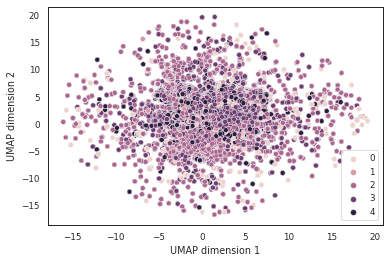

In [20]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=Y['train'])
plt.xlabel('UMAP dimension 1') ; plt.ylabel('UMAP dimension 2')
plt.show()

Note that we do not see a clear separation of the classes in the reduced embedding space. This means that either the parameters of the UMAP should be better tuned to get a better dimensionality reduction, or the word2vec did not work as well as we hoped.

**Standardizing**

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = {'train': scaler.fit_transform(X['train']),
	 'val'	: scaler.transform(X['val']),
	 'test'	: scaler.transform(X['test'])}

**Logistic regression**

We use again L1 regularization. Even though the number of features is much lower now, it is still 200, for which it is nice to have some regularization.

In [ ]:
# regression
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X['train'], Y['train'])

# write to file
with open('./model/word2vec-classifier.pkl', 'wb') as file:
	pickle.dump(clf, file)

In [9]:
# read model
with open('./model/word2vec-classifier.pkl', 'rb') as file:
    clf = pickle.load(file)

**Classification report**

In [10]:
from sklearn.metrics import classification_report

print("\n -------------- train -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['train'], clf.predict(X['train']), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- val -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['val'], clf.predict(X['val']), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- test -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y['test'], clf.predict(X['test']), 
	target_names=le.classes_, output_dict=True)).T)


 -------------- train -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.539801  0.306975  0.391380  1.901980e+05
OBJECTIVE      0.593943  0.448423  0.511025  1.865450e+05
METHODS        0.768107  0.863502  0.813016  7.207890e+05
RESULTS        0.801263  0.827205  0.814027  7.661900e+05
CONCLUSIONS    0.615776  0.640317  0.627807  3.366190e+05
accuracy       0.733422  0.733422  0.733422  7.334222e-01
macro avg      0.663778  0.617284  0.631451  2.200341e+06
weighted avg   0.721848  0.733422  0.722985  2.200341e+06

 -------------- val -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.556031  0.312350  0.400000   2494.000000
OBJECTIVE      0.595238  0.443482  0.508274   2424.000000
METHODS        0.767761  0.863117  0.812651   9541.000000
RESULTS        0.800836  0.825398  0.812932   9977.000000
CONCLUSIONS    0.613080  0.644072  0.628194   4352.000000
accuracy       0.733882  0.733882  0.733882     

**Final score**

In [11]:
from sklearn.metrics import f1_score

print("F1-score (weighted) for test set: ", f1_score(Y['test'], clf.predict(X['test']), average='weighted'))

F1-score (weighted) for test set:  0.7289882139171697


As you can see, it's not really good, if you compare it to the previous method with tf-idf. Although it can be worse. It can probably be improved by increasing the window size $c$ or potentially training for more epochs.

**Confusion matrix**

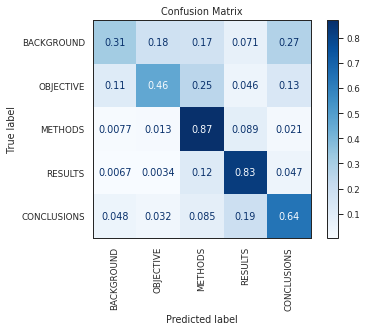

In [12]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X['test'], Y['test'], display_labels=le.classes_, 
	normalize='true', xticks_rotation='vertical', cmap='Blues')
plt.xlabel('Predicted label') ; plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**Receiver Operating Characteristic**

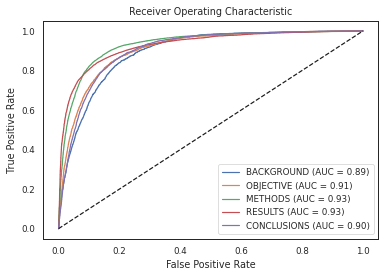

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
	fpr[i], tpr[i], _ = roc_curve(Y['test'] == i, clf.decision_function(X['test'])[:,i])
	roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(le.classes_)):
	plt.plot(fpr[i], tpr[i], label=le.classes_[i]+r' (AUC = %.2f)'%roc_auc[i])
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate') ; plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [14]:
del X ; gc.collect()

12197

## BlueBert
### (Not fine-tuned)

As a last model, we leverage neural networks to classify the sentences. We use the Bidirectional Encoder Representations from Transformers (BERT) model, and on top we use a classifier. 

Transformers make use of an attention mechanism to learn contextual relations between words in a text. The encoder-part of the model reads the text input, and the decoder produces a prediction for the task. The model is trained in two directions, right-to-left and left-to-right, hence "bidirectional", and thereby creates a deeper understanding of the language context and flow.

There are many pre-trained Bert models out there, that are trained on a specific type of text. These models can then be used and fine-tuned for the specific prediction task. In our case, there exists a model BlueBert [1] thath has been trained on the same PubMed dataset that we use for this task. It has shown to have a high performance for this dataset, also when compared to other models such as BioBert. This is quite convenient for our task, and we only need a classifier on top to finish the prediction.

***Note that the BlueBert analysis consits of two parts: one where we do not fine-tune the Bert layers of the model, and one where we do fine-tune the Bert layers of the model. The latter obviously achieves the best performance.***

[1] Peng, Y., Yan, S., and Lu, Z., “Transfer Learning in Biomedical Natural Language Processing: An Evaluation of BERT and ELMo on Ten Benchmarking Datasets”, <i>arXiv e-prints</i> https://arxiv.org/abs/1906.05474, 2019.

Use GPU cards 1-4

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"

**Hyperparameter settings**

We maximize the batch-size to use the full capacity of the GPU. We only train for a few epochs.

In [7]:
BATCH_SIZE = 4096
EPOCHS = 10
LEARNING_RATE = 2e-5
EPSILON = 1e-8

**BlueBert classifier model**

The model consists of the BlueBert model, and a simple classifier on top (with no hidden layers so we can compare with previous methods). We decide not to fine-tune the BlueBert model any further, to reduce training time (if you want to see the results *with* fine-tuning the Bert model, please scroll down). However, note that in our preprocessing, we replaced all our numbers with the token `num`. Potentially, this is not done for the pre-training of the BlueBert model, and therefore, it could be that our model does not capture this feature so well. 

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertModel, AdamW
from transformers import get_linear_schedule_with_warmup


class BertClassifier(nn.Module):
	def __init__(self, freeze_bert=False):
		"""
		BlueBert model with simple classifier on top

		freeze_bert : 	Set False to fine-tune the BERT model
		"""
		super(BertClassifier, self).__init__()

		# BERT model
		self.bert = BertModel.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

		# classifier
		self.classifier = nn.Linear(768, len(le.classes_))

		# freeze the BERT model
		if freeze_bert:
			for param in self.bert.parameters():
				param.requires_grad = False

	def forward(self, X, A):
		"""
		Model in sequential order: BERT - classifier
		"""
		# Feed input to BERT model
		B = self.bert(input_ids=X, attention_mask=A, token_type_ids=None)

		# Feed the last hidden state of the token `[CLS]` to the classifier
		Y_logit = self.classifier(B[0][:,0,:])

		return Y_logit

Note that we trained our model on a GPU server, which is separate from this notebook. We therefore simply load the model, after the training epochs to do the evaluation.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Load **data**

In [10]:
le = LabelEncoder()
le.classes_ = np.array(['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'])
Y = {split : torch.tensor(le.transform(data['y'][split])) for split in ('train', 'val', 'test')}

Tokenize text (`X`), use padding and truncation, and return attention masks (`A`). As this takes a bit of time, save it in a file, so we can skip this step next time.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

In [ ]:
X, A = {}, {}
for split in ('train', 'val', 'test'):
	X[split], _, A[split] = tokenizer.batch_encode_plus(data['x'][split], 
		padding=True, truncation=True, max_length=80, return_tensors="pt").values()
	torch.save(X[split], './data/bert/bluebert_x_'+split)
	torch.save(A[split], './data/bert/bluebert_a_'+split)

In [11]:
X = {split : torch.load('./data/bert/bluebert_x_'+split) for split in ('train', 'val', 'test')}
A = {split : torch.load('./data/bert/bluebert_a_'+split) for split in ('train', 'val', 'test')}

Create dataset and dataloader

In [12]:
dataset = {split: TensorDataset(X[split], A[split], Y[split]) for split in ('train', 'val', 'test')}

dataloader = {'train': DataLoader(dataset['train'], sampler=RandomSampler(dataset['train']), batch_size=BATCH_SIZE),
			  'val'	 : DataLoader(dataset['val'], sampler=SequentialSampler(dataset['val']), batch_size=BATCH_SIZE),
			  'test' : DataLoader(dataset['test'], sampler=SequentialSampler(dataset['test']), batch_size=BATCH_SIZE)} # because we run this locally on a laptop

**Training loop of BlueBert classifier**

We use crossentropy loss, the AdamW optimizer, and a linear learning rate scheduler. During the training loop, we save the labels (`Y_true`) and the predictions (`Y_pred`), so that we can easily create a classification report and calculate metrics afterwards.

The training loop consists of two parts: the training and evaluation part, which is done with the training and validation set respectively. In the training part, we do a forward pass to calculate the loss and gradients, and then a backwards pass to update the model. We clip the norm of the gradients to one to prevent exploding gradients. Afterwards we save the model. In the evaluation phase, we evaluate the updated model on the validation set using a forward pass.

In [ ]:
# model
model = BertClassifier(freeze_bert=True)
model = nn.DataParallel(model) # use multiple GPUs
model.to(device)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

# scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
	num_training_steps=len(dataloader['train'])*EPOCHS)

# total loss over all batches
total_loss = {split: np.zeros(EPOCHS) for split in ('train', 'val', 'test')}

# keep predictions and labels, so that we can calculate the classification report later
# note that Y_true is Y, but then shuffled
Y_pred = {split: {e: [] for e in range(EPOCHS)} for split in ('train', 'val')}
Y_true = {split: {e: [] for e in range(EPOCHS)} for split in ('train', 'val')}

In [ ]:
for epoch in range(EPOCHS):

	# training phase
	model.train()

	for i, batch in enumerate(tqdm(dataloader['train'])):
		x, a, y = tuple(b.to(device) for b in batch)

		model.zero_grad()

		# forward pass
		y_pred = model(x, a)

		# compute loss
		loss = loss_fn(y_pred, y)

		# append batch calculations
		Y_pred['train'][epoch].append(y_pred.detach().cpu())
		Y_true['train'][epoch].append(y.detach().cpu())

		total_loss['train'][epoch] += loss.item()

		# backward pass
		loss.backward()

		# clip norm of gradients to one to prevent exploding gradient
		torch.nn.utils.clip_grad_norm(model.parameters(), 1.)

		# update parameters and learning rate
		optimizer.step()
		scheduler.step()

	# aggregate batch calculations
	Y_pred['train'][epoch] = torch.vstack(Y_pred['train'][epoch])
	Y_true['train'][epoch] = torch.hstack(Y_true['train'][epoch])

	total_loss['train'][epoch] /= len(dataloader['train'])

	# save Y_true and Y_pred
	torch.save(Y_true['train'], './data/bert/bluebert_y_train')
	torch.save(Y_pred['train'], './data/bert/bluebert_ypred_train')

	# save total loss
	torch.save(total_loss, './model/bluebert-loss')

	# save model
	torch.save({'epoch': epoch,
				'model_state_dict': model.state_dict(),
				'optimizer_state_dict': optimizer.state_dict()},
				'./model/bluebert-classifier-%s.model'%epoch)

	# evaluate model on validation set after each epoch
	model.eval()

	for i, batch in enumerate(tqdm(dataloader['val'])):
		x, a, y = tuple(b.to(device) for b in batch)

		with torch.no_grad():
			# forward pass
			y_pred = model(x, a)

		# compute loss
		loss = loss_fn(y_pred, y)

		# append batch calculations
		Y_pred['val'][epoch].append(y_pred.detach().cpu())
		Y_true['val'][epoch].append(y.detach().cpu())

		total_loss['val'][epoch] += loss.item()

	# aggregate batch calculations
	Y_pred['val'][epoch] = torch.vstack(Y_pred['val'][epoch])
	Y_true['val'][epoch] = torch.hstack(Y_true['val'][epoch])

	total_loss['val'][epoch] /= len(dataloader['val'])

	# save Y_true and Y_pred
	torch.save(Y_true['val'], './data/bert/bluebert_y_val')
	torch.save(Y_pred['val'], './data/bert/bluebert_ypred_val')

	# save total loss
	torch.save(total_loss, './model/bluebert-loss')

Just as an illustration, this is what the output of the above code block would have looked like:

```
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:32<00:00,  1.96s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.63s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:31<00:00,  1.95s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.61s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:30<00:00,  1.95s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.63s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:27<00:00,  1.95s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.60s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:31<00:00,  1.95s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.60s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:32<00:00,  1.96s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.60s/it]
100%|████████████████████████████████████████████████████████████████████| 538/538 [17:31<00:00,  1.95s/it]
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.61s/it]
```

**Evaluation of BlueBert classifier**

From all epochs, we select the model with the lowest validation loss. Using the test set, we evaluate the model in this final stage. 

In [13]:
total_loss = torch.load('./model/bluebert-loss')

Y_true = {split: torch.load('./data/bert/bluebert_y_'+split) for split in ('train', 'val')}
Y_pred = {split: torch.load('./data/bert/bluebert_ypred_'+split) for split in ('train', 'val')}

# pick model with lowest validation loss
best_epoch = np.argmin(total_loss['val'])
print("Best epoch: ", best_epoch)

Best epoch:  9


**Plot the loss function over the epochs**

Note that the loss function shows a bump at epoch 2. That is because the training was interrupted due to a loss of internet connection. I forgot to save the state of the learning rate scheduler, but simply continued training with the last saved model, so that is why there is a slight bump.

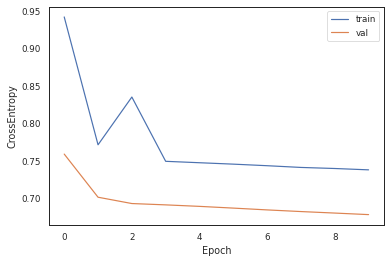

In [14]:
pd.DataFrame.from_dict(total_loss)[['train', 'val']].plot()
plt.xlabel('Epoch') ; plt.ylabel('CrossEntropy')
plt.show()

**Load the best model**

In [15]:
# load model
model = BertClassifier(freeze_bert=True)
model = nn.DataParallel(model)
model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

checkpoint = torch.load('./model/bluebert-classifier-%s.model'%best_epoch, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [16]:
# select only column of Y of best epoch
Y_true = {split: Y_true[split][best_epoch] for split in ('train', 'val')}
Y_pred = {split: Y_pred[split][best_epoch] for split in ('train', 'val')}
Y_true['test'], Y_pred['test'] = [], []

In [17]:
total_loss = {split: total_loss[split][best_epoch] for split in ('train', 'val', 'test')}

**Evaluate best model on test set**

In [ ]:
model.eval()

for i, batch in enumerate(tqdm(dataloader['test'])):
	x, a, y = tuple(b.to(device) for b in batch)

	with torch.no_grad():
		# forward pass
		y_pred = model(x, a)

	# compute loss
	loss = loss_fn(y_pred, y)

	# append batch calculations
	Y_pred['test'].append(y_pred.detach().cpu())
	Y_true['test'].append(y.detach().cpu())

	total_loss['test'] += loss.item()

# aggregate batch calculations
Y_pred['test'] = torch.vstack(Y_pred['test'])
Y_true['test'] = torch.hstack(Y_true['test'])

total_loss['test'] /= len(dataloader['test'])

In [ ]:
# save Y_true and Y_pred
torch.save(Y_true['test'], './data/bert/bluebert_y_test')
torch.save(Y_pred['test'], './data/bert/bluebert_ypred_test')

In [18]:
# load Y_true and Y_pred
Y_true['test'] = torch.load('./data/bert/bluebert_y_test')
Y_pred['test'] = torch.load('./data/bert/bluebert_ypred_test')

**Classification report**

In [19]:
from sklearn.metrics import classification_report

print("\n -------------- train -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['train'], torch.argmax(Y_pred['train'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- val -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['val'], torch.argmax(Y_pred['val'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- test -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)


 -------------- train -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.531376  0.311503  0.392762  1.919210e+05
OBJECTIVE      0.635758  0.516880  0.570188  1.865540e+05
METHODS        0.758237  0.851782  0.802292  7.208580e+05
RESULTS        0.793499  0.787781  0.790630  7.662310e+05
CONCLUSIONS    0.618444  0.675152  0.645555  3.368130e+05
accuracy       0.727054  0.727054  0.727054  7.270535e-01
macro avg      0.667463  0.628620  0.640285  2.202377e+06
weighted avg   0.718982  0.727054  0.718916  2.202377e+06

 -------------- val -------------- : 
               precision    recall  f1-score      support
BACKGROUND     0.577880  0.350397  0.436265   2520.00000
OBJECTIVE      0.633094  0.580858  0.605852   2424.00000
METHODS        0.790047  0.866890  0.826687   9541.00000
RESULTS        0.818947  0.790218  0.804326   9977.00000
CONCLUSIONS    0.627013  0.715434  0.668312   4354.00000
accuracy       0.748230  0.748230  0.748230      0.748

**F1-score**

In [20]:
from sklearn.metrics import f1_score

print("F1-score (weighted) for test set: ", f1_score(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), average='weighted'))

F1-score (weighted) for test set:  0.7407037085763539


**Confusion matrix**

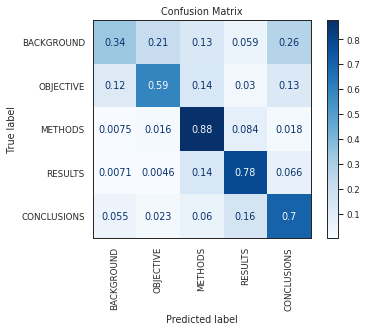

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_) 
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.xlabel('Predicted label') ; plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**Receiver Operating Characteristic**

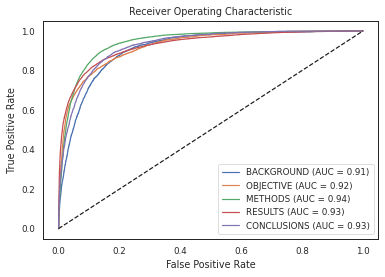

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
	fpr[i], tpr[i], _ = roc_curve(Y_true['test'] == i, F.softmax(Y_pred['test'], dim=1)[:,i]) # TODO
	roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(le.classes_)):
	plt.plot(fpr[i], tpr[i], label=le.classes_[i]+r' (AUC = %.2f)'%roc_auc[i])
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate') ; plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

As we can see, the final result is not bad. It is slightly better compared to word2vec, however worse than the tf-idf. We think this is probably because we replaced all numbers in the document with the token `num`. If this token was not learned in the BlueBert model, it makes sense that the performance is lower, as `num` was often one of the most important features in the tf-idf analysis. 

## BlueBert 
### (fine-tuned)

As we mentioned above, our final performance is not that great, as we did not fine-tune the BlueBert model. In this last step, **we do fine-tune the Bert-part of the model** (so we do not freeze its weights). The results can be viewed underneath.

In [7]:
BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 2e-5
EPSILON = 1e-8

In [10]:
# data
le = LabelEncoder()
le.classes_ = np.array(['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'])
Y = {split : torch.tensor(le.transform(data['y'][split])) for split in ('train', 'val', 'test')}

X = {split : torch.load('./data/bert/bluebert_x_'+split) for split in ('train', 'val', 'test')}
A = {split : torch.load('./data/bert/bluebert_a_'+split) for split in ('train', 'val', 'test')}

dataset = {split: TensorDataset(X[split], A[split], Y[split]) for split in ('train', 'val', 'test')}

dataloader = {'train': DataLoader(dataset['train'], sampler=RandomSampler(dataset['train']), batch_size=BATCH_SIZE),
			  'val'	 : DataLoader(dataset['val'], sampler=SequentialSampler(dataset['val']), batch_size=BATCH_SIZE),
			  'test' : DataLoader(dataset['test'], sampler=SequentialSampler(dataset['test']), batch_size=BATCH_SIZE)}

Note that underneath we do not freeze the Bert layer

In [11]:
# model
model = BertClassifier(freeze_bert=False)
model = nn.DataParallel(model) # use multiple GPUs
model.to(device)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

# scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
	num_training_steps=len(dataloader['train'])*EPOCHS)

In [12]:
# total loss over all batches
total_loss = {split: np.zeros(EPOCHS) for split in ('train', 'val', 'test')}

# keep predictions and labels, so that we can calculate the classification report later
# note that Y_true is Y, but then shuffled
Y_pred = {split: {e: [] for e in range(EPOCHS)} for split in ('train', 'val')}
Y_true = {split: {e: [] for e in range(EPOCHS)} for split in ('train', 'val')}

**Training loop**

Again trained on an external GPU (but for convenience, we copied the terminal output underneath).

In [ ]:
for epoch in range(EPOCHS):

	# training phase
	model.train()

	for i, batch in enumerate(tqdm(dataloader['train'])):
		x, a, y = tuple(b.to(device) for b in batch)

		model.zero_grad()

		# forward pass
		y_pred = model(x, a)

		# compute loss
		loss = loss_fn(y_pred, y)

		# append batch calculations
		Y_pred['train'][epoch].append(y_pred.detach().cpu())
		Y_true['train'][epoch].append(y.detach().cpu())

		total_loss['train'][epoch] += loss.item()

		# backward pass
		loss.backward()

		# clip norm of gradients to one to prevent exploding gradient # TODO: should I do this?
		torch.nn.utils.clip_grad_norm(model.parameters(), 1.)

		# update parameters and learning rate
		optimizer.step()
		scheduler.step()

	# aggregate batch calculations
	Y_pred['train'][epoch] = torch.vstack(Y_pred['train'][epoch])
	Y_true['train'][epoch] = torch.hstack(Y_true['train'][epoch])

	total_loss['train'][epoch] /= len(dataloader['train'])

	# save Y_true and Y_pred
	torch.save(Y_true['train'], './data/bert/extra/bluebert_y_train')
	torch.save(Y_pred['train'], './data/bert/extra/bluebert_ypred_train')

	# save total loss
	torch.save(total_loss, './model/bluebert-loss')

	# save model
	torch.save({'epoch': epoch,
				'model_state_dict': model.state_dict(),
				'optimizer_state_dict': optimizer.state_dict()},
				'./model/bluebert-classifier-extra-%s.model'%epoch)

	# evaluate model on validation set after each epoch
	model.eval()

	for i, batch in enumerate(tqdm(dataloader['val'])):
		x, a, y = tuple(b.to(device) for b in batch)

		with torch.no_grad():
			# forward pass
			y_pred = model(x, a)

		# compute loss
		loss = loss_fn(y_pred, y)

		# append batch calculations
		Y_pred['val'][epoch].append(y_pred.detach().cpu())
		Y_true['val'][epoch].append(y.detach().cpu())

		total_loss['val'][epoch] += loss.item()

	# aggregate batch calculations
	Y_pred['val'][epoch] = torch.vstack(Y_pred['val'][epoch])
	Y_true['val'][epoch] = torch.hstack(Y_true['val'][epoch])

	total_loss['val'][epoch] /= len(dataloader['val'])

	# save Y_true and Y_pred
	torch.save(Y_true['val'], './data/bert/extra/bluebert_y_val')
	torch.save(Y_pred['val'], './data/bert/extra/bluebert_ypred_val')

	# save total loss
	torch.save(total_loss, './model/bluebert-loss-extra')

```
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:04:25<00:00,  1.11it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.32it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:03:39<00:00,  1.13it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.33it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:03:33<00:00,  1.13it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.32it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:04:01<00:00,  1.12it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.33it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:03:46<00:00,  1.12it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.33it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:04:40<00:00,  1.11it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.32it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:04:10<00:00,  1.12it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.31it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:03:54<00:00,  1.12it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.32it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:04:21<00:00,  1.11it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.33it/s]
100%|████████████████████████████████████████████████████████████████| 4302/4302 [1:03:44<00:00,  1.12it/s]
100%|██████████████████████████████████████████████████████████████████████| 57/57 [00:24<00:00,  2.33it/s]
```

**Evaluate best model**

In [13]:
total_loss = torch.load('./model/bluebert-loss-extra')

Y_true = {split: torch.load('./data/bert/extra/bluebert_y_'+split) for split in ('train', 'val')}
Y_pred = {split: torch.load('./data/bert/extra/bluebert_ypred_'+split) for split in ('train', 'val')}

# pick model with lowest validation loss
best_epoch = np.argmin(total_loss['val'])
print("Best epoch: ", best_epoch)

Best epoch:  1


Plot loss

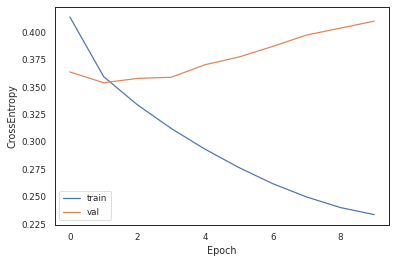

In [14]:
pd.DataFrame.from_dict(total_loss)[['train', 'val']].plot()
plt.xlabel('Epoch') ; plt.ylabel('CrossEntropy')
plt.show()

*Note: in hindsight, it might have been better to include regularization here, or decrease the learning rate, as it clearly overfits already after one epoch.*

In [16]:
# load model
model = BertClassifier(freeze_bert=True)
model = nn.DataParallel(model)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)

checkpoint = torch.load('./model/bluebert-classifier-extra-%s.model'%best_epoch, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [17]:
# select only column of Y of best epoch
Y_true = {split: Y_true[split][best_epoch] for split in ('train', 'val')}
Y_pred = {split: Y_pred[split][best_epoch] for split in ('train', 'val')}
Y_true['test'], Y_pred['test'] = [], []

total_loss = {split: total_loss[split][best_epoch] for split in ('train', 'val', 'test')}

In [ ]:
# evaluate model on test set
model.eval()

for i, batch in enumerate(tqdm(dataloader['test'])):
	x, a, y = tuple(b.to(device) for b in batch)

	with torch.no_grad():
		# forward pass
		y_pred = model(x, a)

	# compute loss
	loss = loss_fn(y_pred, y)

	# append batch calculations
	Y_pred['test'].append(y_pred.detach().cpu())
	Y_true['test'].append(y.detach().cpu())

	total_loss['test'] += loss.item()

# aggregate batch calculations
Y_pred['test'] = torch.vstack(Y_pred['test'])
Y_true['test'] = torch.hstack(Y_true['test'])

total_loss['test'] /= len(dataloader['test'])

# save Y_true and Y_pred
torch.save(Y_true['test'], './data/bert/extra/bluebert_y_test')
torch.save(Y_pred['test'], './data/bert/extra/bluebert_ypred_test')

In [19]:
# load Y_true and Y_pred
Y_true['test'] = torch.load('./data/bert/extra/bluebert_y_test')
Y_pred['test'] = torch.load('./data/bert/extra/bluebert_ypred_test')

**Classification report**

In [20]:
from sklearn.metrics import classification_report

print("\n -------------- train -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['train'], torch.argmax(Y_pred['train'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- val -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['val'], torch.argmax(Y_pred['val'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)
print("\n -------------- test -------------- : \n", 
	pd.DataFrame.from_dict(classification_report(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), 
	target_names=le.classes_, output_dict=True)).T)


 -------------- train -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.662031  0.694953  0.678092  1.919210e+05
OBJECTIVE      0.773171  0.642752  0.701955  1.865540e+05
METHODS        0.917396  0.946339  0.931643  7.208580e+05
RESULTS        0.909322  0.909422  0.909372  7.662310e+05
CONCLUSIONS    0.824793  0.822584  0.823687  3.368130e+05
accuracy       0.866947  0.866947  0.866947  8.669469e-01
macro avg      0.817343  0.803210  0.808950  2.202377e+06
weighted avg   0.865955  0.866947  0.865834  2.202377e+06

 -------------- val -------------- : 
               precision    recall  f1-score       support
BACKGROUND     0.673375  0.690476  0.681818   2520.000000
OBJECTIVE      0.754664  0.667492  0.708406   2424.000000
METHODS        0.923148  0.941725  0.932344   9541.000000
RESULTS        0.898298  0.915405  0.906771   9977.000000
CONCLUSIONS    0.837870  0.805926  0.821587   4354.000000
accuracy       0.867053  0.867053  0.867053     

**F1-score**

In [21]:
from sklearn.metrics import f1_score

print("F1-score (weighted) for test set: ", f1_score(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), average='weighted'))

F1-score (weighted) for test set:  0.8648708438390317


As you can see, fine-tuning the BlueBert model, makes a huge difference in terms of performance, most likely due to our encoding of numbers `num`. These results look good.

**Confusion matrix**

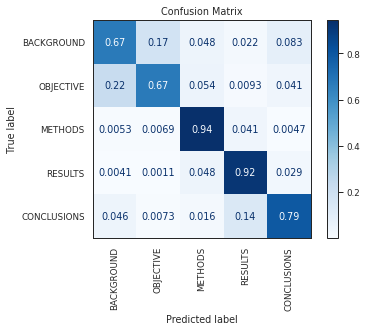

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_true['test'], torch.argmax(Y_pred['test'], dim=1), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_) 
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.xlabel('Predicted label') ; plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

As you can see, the performance of the fine-tuned BlueBert model is much better than the previous models, specifically with regards to the prediction of the `BACKGROUND` label.

**Receiver Operating Characteristic**

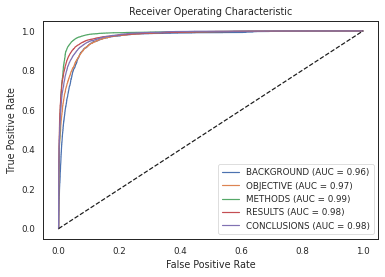

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(le.classes_)):
	fpr[i], tpr[i], _ = roc_curve(Y_true['test'] == i, F.softmax(Y_pred['test'], dim=1)[:,i]) # TODO
	roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(le.classes_)):
	plt.plot(fpr[i], tpr[i], label=le.classes_[i]+r' (AUC = %.2f)'%roc_auc[i])
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate') ; plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

## Final discussion

Comparing the the models *tf-idf*, *word2vec* and *BlueBert* to obtain a representation of the sentences in the PubMed abstracts, we find that a fine-tuned BlueBert model obtains the best performance on the test set. 

Overall, the find the following **weighted F1-scores**: 

**model** | **weighted F1-score**
:--- | :---:
tf-idf | 0.80
word2vec | 0.73
BlueBert (not fine-tuned) | 0.74
BlueBert (fine-tuned) | 0.86


The word2vec model potentially obtains a lower performance due to our lower window size, or not having enough training epochs. The BlueBert model clearly needs to be fine-tuned to obtain the best performance.

To improve our models, we should perform hyperparameter-optimization for each model. We simply choose hyperparameters that made sense, instead of optimizing them. Optimizing them should lead to better performance.